# Converting Between Reference Frames
This notebook will demonstrate how to convert between various reference frames. It will also show how to use SPICE.jl to access JPL ephemeris data.


In [104]:
@time using ThreeBodyProblem
@time using DifferentialEquations.OrdinaryDiffEq
@time using LinearAlgebra
@time using Plots
@time using SPICE

  0.000133 seconds (99 allocations: 7.859 KiB)
  0.000075 seconds (99 allocations: 7.844 KiB)
  0.000069 seconds (99 allocations: 7.844 KiB)
  0.000044 seconds (99 allocations: 7.844 KiB)
  0.000050 seconds (115 allocations: 9.297 KiB)


## Rotating and Inertial Frames
Let's convert between the rotating and inertial frames to see how different things look.

### Set up initial condition in rotating frame
The Lagrange points are stationary in the rotating frame, therefore they should trace out circles in the inertial frame.

In [105]:
sys = earth_moon() # create the Earth-Moon system
Lpts = computeLpts(sys) # compute the L1, L2, L3, L4, and L5 Lagrange points
rv_rot = [Lpts[1]; zeros(3)] # state of the L1 point in the rotating frame

6-element Vector{Float64}:
 0.8369171147702252
 0.0
 0.0
 0.0
 0.0
 0.0

### Integrate with CR3BPdynamics

In [106]:
tspan = (0.0, 2π) # time span of the simulation
prob_rot = ODEProblem(CR3BPdynamics!, rv_rot, tspan, sys) # create the ODE problem
sol_rot = solve(prob_rot, TsitPap8(), reltol=1e-12, abstol=1e-12); # solve the ODE problem

### Convert to inertial frame and integrate with CR3BPinert

In [107]:
rv_inert = rot2inert(rv_rot, 0, sys, origin=:barycenter) # convert the state to the inertial frame
prob_inert = ODEProblem(CR3BPinert!, rv_inert, tspan, sys) # create the ODE problem
sol_inert = solve(prob_inert, TsitPap8(), reltol=1e-12, abstol=1e-12); # solve the ODE problem

### Plot the results

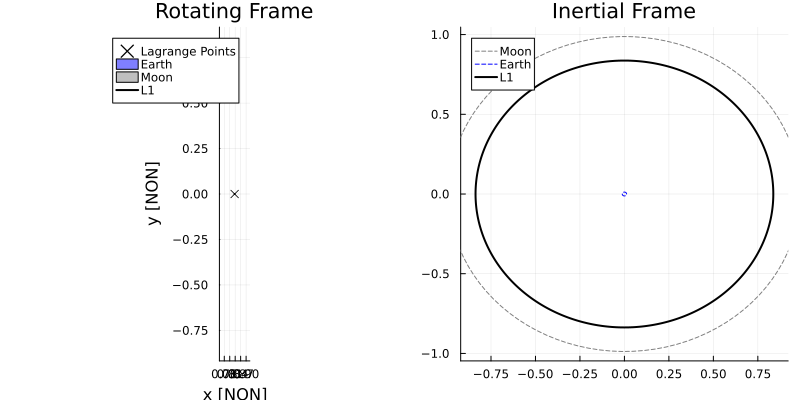

In [108]:
p_rot = plot(sys, title="Rotating Frame"); # plot the system in the rotating frame
plot!(p_rot, sol_rot, idxs=(1,2), label="L1",lw=2, color=:black); # plot the solution

p_inert = plot(circle(1-sys.μ), title="Inertial Frame", linestyle=:dash, label="Moon", color=:gray); # plot the Orbit of the Moon in the inertial frame
plot!(p_inert, circle(sys.μ), linestyle=:dash, label="Earth", color=:blue); # plot the orbit of the Earth
plot!(p_inert, sol_inert ,idxs=(1,2), label="L1",lw=2, color=:black); # plot the solution

plot(p_rot, p_inert, layout=(1,2), size=(800,400)) # plot the two frames side by side


As we expected, the L1 point doesn't move in the rotating frame, but moves in a perfect circle in the inertial frame.

### Changing the Origin
We can also change whether the origin of the frame lies at the barycenter or the center of the primary or secondary bodies.

In [109]:
# Define the Saturn/Enceladus CR3BP system
sys = saturn_enceladus();

# Initial Conditions for a halo orbit (obtained from https://ssd.jpl.nasa.gov/tools/periodic_orbits.html)
rv₀ = [ 1.002850044069033
                        0
        0.004808592996246
       -0.000000000000001
       -0.005747591930694
       -0.000000000000006]

# Period of the halo orbit
T₀ = 2.445783783357601

2.445783783357601

Let's integrate this halo orbit in the rotating frame, but convert it to the inertial frame centered around Enceladus.

In [110]:
prob_halo = ODEProblem(CR3BPdynamics!, rv₀, (0.0, 4*T₀), sys) # create the ODE problem
sol_halo = solve(prob_halo, TsitPap8(), reltol=1e-12, abstol=1e-12); # solve the ODE problem
sol_halo_inert = [rot2inert(sol_halo.u[i], sol_halo.t[i], sys, origin=:sec) for i in eachindex(sol_halo)]; # convert the solution to the inertial frame

Plot the result

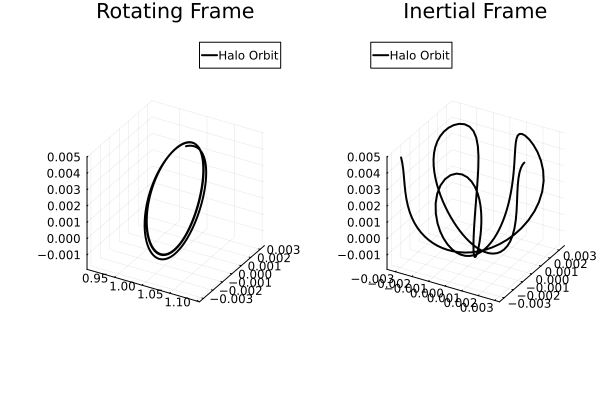

In [111]:
p_halo_rot = plot(sol_halo, idxs=(1,2,3), label="Halo Orbit",lw=2, color=:black, title="Rotating Frame"); # rotating frame
p_halo_inert = plot(sol_halo_inert, label="Halo Orbit", lw=2, color=:black, title="Inertial Frame"); # plot the solution in the inertial frame

plot(p_halo_rot, p_halo_inert, layout=(1,2)) # plot the two frames side by side

## Dimensionless and Dimensional Coordinates
We can quickly normalize and de-normalize states using the following functions

In [112]:
rv_rot_dim = dimensionalize(rv_rot, sys) # convert the state to the dimensional coordinates
rv_rot_nondim = nondimensionalize(rv_rot_dim, sys) # convert the state to the nondimensional coordinates
rv_rot == rv_rot_nondim ? "The two states are equal" : "The two states are not equal"

"The two states are equal"

The output of dimensionalize is in units of km for position and km/s for velocity. It doesn't matter if the vector is in the rotating or inertial frame.

In [113]:
rv_inert_dim = dimensionalize(rv_inert, sys) # convert the state to the dimensional coordinates
rv_inert_nondim = nondimensionalize(rv_inert_dim, sys) # convert the state to the nondimensional coordinates
rv_inert == rv_inert_nondim ? "The two states are equal" : "The two states are not equal"

"The two states are equal"

## East-North-Up (ENU) Frame
The East-North-Up (ENU) frame is a fixed frame with the z-axis pointing up, the x-axis pointing east, and the y-axis pointing north. Let's define a state vector in the ENU frame. This particular state is from a meteor observed by the ALTAIR Radar in the Kwajalein Atoll


In [114]:
r_enu = [191.0973115173407; 78.7745585024403; 57.3291938159787] # [km]
v_enu = [-52.199447002937305; -21.517740337533645; -15.659828241680069] #[km/s]
rv_enu = [r_enu; v_enu]

6-element Vector{Float64}:
 191.0973115173407
  78.7745585024403
  57.3291938159787
 -52.199447002937305
 -21.517740337533645
 -15.659828241680069

In order for the ENU frame to have any global significance, we need to know the location of its origin.

In [115]:
# coordinates of observer (ALTAIR radar)
ϕ = 9.3987 # [deg] latitude
λ = 167.482 # [deg] longitude
h = 0.083532 # [km] altitude

0.083532

## Earth-Centered Earth-Fixed (ECEF) Frame
ECEF is a fixed frame with the Earth's rotation axis as the z-axis and the x-axis pointing to the intersection of the equator with the prime meridian, with the y-axis completing the right-handed coordinate system.

### Let's convert the ENU state vector to the ECEF frame
We can use the enu2ecef() function to do this. It needs the ENU state vector, the latitude, longitude, and altitude of the observer

In [116]:
rv_ecef = enu2ecef(rv_enu, ϕ, λ, h, geodetic=true, ang_unit=:deg) # geodetic and ang_unit are 'true' and ':deg' by default

6-element Vector{Float64}:
 -6228.051677636693
  1187.0280181697815
  1121.8584487359572
    22.965986922518383
    48.371544115226904
   -23.786189307837354

### There is also an inverse function, ecef2enu()
Let's check that we get the same r_enu vector when working backwards


In [117]:
rv_enu ≈ ecef2enu(rv_ecef, ϕ, λ, h) ? "The vectors are approximately the same" : "The vectors don't match" # We can use the \approx<tab> (≈) operator to check if two vectors are approximately equal

"The vectors are approximately the same"

This interesting syntax is called a ternary operator. It is equivalent to the following if-else statement:
```julia
if rv_enu ≈ ecef2enu(rv_ecef, ϕ, λ, h)
    "The vectors are approximately the same"
else
    "The vectors don't match"
end
```


## Earth-Centered Inertial (ECI) Frame 
ECI has the z-axis pointing in the direction of the Earth's rotation axis, just like ECEF. However, the x-axis points in the direction of Vernal Equinox (pointing from the Earth to the Sun on the first day of Spring) and the y-axis completes the right-handed coordinate system.

### Let's convert the ECEF state vector to the ECI frame.
We need a date and time to do this.


In [118]:
# UT1 November 17, 2000 15:00:05.634
datetime = "November 17, 2000 15:00:05.634"
date = [2000,11,17,15,0,5.634] #[Y,M,D,h,m,s] observation date
mjd = date2mjd(date) # [days] modified julian date
θ = mjd2gmst(mjd) # [rad] Greenwich Mean Sidereal time

4.9218307331105535

Let's check that we get the same r_ecef vector when working backwards

In [119]:
rv_eci = ecef2eci(rv_ecef, θ, ang_unit=:rad)
rv_ecef ≈ eci2ecef(rv_eci, θ) ? "The vectors are approximately the same" : "The vectors don't match"

"The vectors are approximately the same"

The fact that these transformations are invertible allows for easy conversions between frames.

## Sun-Centered Inertial (SCI) Frame 
SCI is very similar to ECI, except that the z-axis points in the direction normal to the ecliptic plane (the plane of the Earth's orbit around the Sun). The x-axis points in the direction of the Vernal Equinox, and the y-axis completes the right-handed coordinate system.

### Let's convert the ECI state vector to the SCI frame.
We need the state of the Sun on the given date to do this. We can get this from SPICE.jl.


In [120]:
furnsh("kernels/de440s.bsp") # load the kernels for the sun's position
furnsh("kernels/naif0012.tls") # load the kernels for the time
et = str2et(datetime) # [s] convert the date and time to ephemeris time
rv_sun_eci, = spkezr("Sun",et,"J2000","NONE","Earth") # [km] and [km/s] position and velocity of the Sun in the ECI frame


([-8.361504514533903e7, -1.1190656289919405e8, -4.851685744358933e7, 25.046421457913553, -15.35899691124815, -6.657764175193066], 493.2739710170643)

We also need the obliquity of the Ecliptic Plane ε, but it is given as a default already.

In [121]:
rv_sci = eci2sci(rv_eci, rv_sun_eci, ε = 23.439292) # ε is 23.439292° by default. We've just included it in this function call for transparency.
rv_eci ≈ sci2eci(rv_sci, rv_sun_eci) ? "The vectors are approximately the same" : "The vectors don't match"

"The vectors are approximately the same"